# Scalable Inference with a Sparse GP 

## Optional Preparation
**Warning:** This tutorial assumes you have familiarity with Gaussian Processes and their implementations in stochastic variational inference. It may help if you do the following:
1. Read the [Non-Gaussian Likelihoods][1] `tinygp` tutorial, our example roughly continues from there.
2. Familiarize yourself with stochastic variational inference (see [Appendix A](#appendix-a-svi-basics)). 
3. Familiarize yourself with sparse gaussian processes (see paper on [Scalable Variational Gaussian Process Classification][2] for the theory and motivations and [Appendix B](#appendix-b-numpyro-sparse-gp-elbo) for an explanation of how our sparse GP model is being implemented in `numpyro`).

<!-- ### Reference: -->

[1]: <https://tinygp.readthedocs.io/en/latest/tutorials/likelihoods.html> "Non-Gaussian Likelihoods"
[2]: <https://proceedings.mlr.press/v38/hensman15.pdf> "Scalable Variational Gaussian Process Classification"

## Example: Non-Gaussian Likelihood Fit 
Similar to `tinygp` tutorial above. In our example, we generate Poisson samples from a rate function that has a Gaussian shape. We model this with a log-GP prior to ensure that the rate is positive.

### Generate Poisson Data

In [1]:
# necessary for running on GPU
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


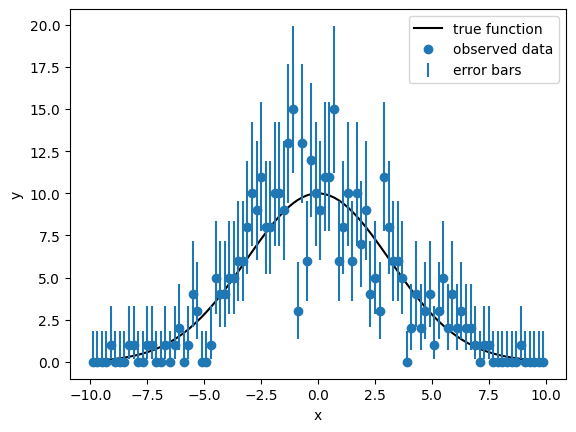

In [2]:
import sys
sys.path.append("..")
from utils import custom
from utils.custom import log_like_poisson

import numpy as np # for numerical operations
import matplotlib.pyplot as plt # for plotting
import tqdm

import jax # for faster numerical operations
import jax.numpy as jnp # for numpy-like syntax
from jax.scipy import stats
from jax import jit

from tinygp import GaussianProcess, kernels
import numpyro # for inference and probabilistic programming
import numpyro.distributions as dist
from numpyro.infer import Predictive

# run code with 64-bit precision (slows down code but increases numerical stability)
jax.config.update("jax_enable_x64", True)

# parameters
p_tr = [0., np.pi, 10.]
mu_tr, sigma_tr, N_tr = p_tr

# generate data
x_bin = jnp.linspace(-10,10,101) # 10 random points between -1 and 1
x = 0.5 * (x_bin[:-1] + x_bin[1:])
log_rate = -(x-mu_tr)**2. / (2. * sigma_tr**2.)
y = N_tr * jnp.exp(log_rate)
y_obs = jax.random.poisson(jax.random.PRNGKey(23),y)

# estimate error bars
yerr = jnp.array([custom.poisson_interval(k) for k in y_obs.T]).T

# plot data with error bars
plt.plot(x, y, 'k', label='true function')
plt.plot(x, y_obs, 'o', label='observed data')
plt.errorbar(x, y_obs, yerr = yerr, c = 'C0', fmt = 'none', label='error bars')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

### Build model and run inference with SVI
We use SVI to perform inference because it allows for subsampling, unlike HMC/NUTS-based MCMC sampling. As NumPyro allows us to perform inference once we define a `model`, one may fit a sparse GP with MCMC sampling. Without subsampling, the sparse GP loses much of its benefits, as one has to sample over the large-dimensional input space `x` anyways. If you want to perform an HMC implementation that allows for subsampling, you may want to adapt our sparse GP model to the code in [Example: Hamiltonian Monte Carlo with Energy Conserving Subsampling][1].

<!-- ### References -->
[1]: <https://num.pyro.ai/en/stable/examples/hmcecs.html> "Example: Hamiltonian Monte Carlo with Energy Conserving Subsampling"

In [3]:
# Unconstrained SVI fit
def model(x, y=None):
    '''
    Numpyro model for 1D Poisson regression with Gaussian Process prior on log_rate

    Parameters
    ----------
    x : array
        x values (where observations are made)
    y : array
        y values (observations)
    '''
    # define GP kernel (with hyperparameters optimized during fitting)
    kernel = custom.load_kernel(before_fit = True)

    # define Gaussian Process prior on log_rate (zero mean and ExpSquared kernel)
    gp = GaussianProcess(kernel, x, diag = 1e-3)
    log_rate = numpyro.sample("log_rate", gp.numpyro_dist())
    rate = jnp.exp(log_rate)
    
    # load function values and compute log likelihood
    numpyro.factor('log_likelihood', log_like_poisson(rate, y))

In [4]:
# run SVI
svi, guide = custom.load_svi(model, lr = 0.01, num_particles = 16)
rng_key = jax.random.PRNGKey(0)
svi_results = svi.run(rng_key, 30000, x, y=y_obs)

100%|██████████| 30000/30000 [00:45<00:00, 661.26it/s, init loss: 69851.1091, avg. loss [28501-30000]: 186.3732]


In [5]:
# sample from GP posterior using guide sample_posterior function
rng_key, key = jax.random.split(rng_key)
samples = guide.sample_posterior(key, svi_results.params, (1000,))
gp_samples = jnp.exp(samples['log_rate'])

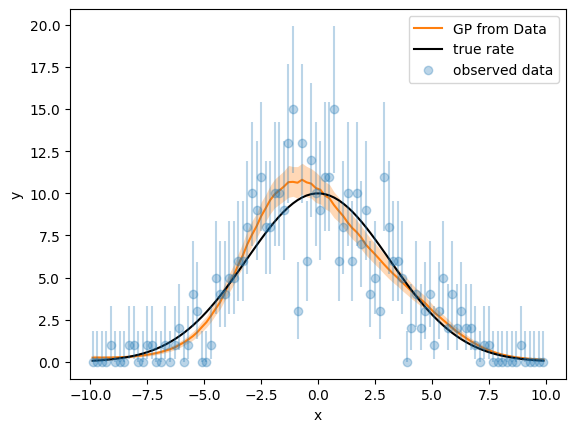

In [6]:
q = np.quantile(gp_samples, [0.16,0.5,0.84], axis = 0)

# plot guide (posterior approximation)
plt.plot(x, q[1], color = 'C1', label = 'GP from Data')
plt.fill_between(
    x,
    q[0],
    q[2],
    alpha=0.3,
    lw=0,
    color="C1",
)

# plot data with error bars 
plt.plot(x, y, "k", label="true rate")
plt.plot(x, y_obs, 'o', label='observed data', alpha = 0.3)
plt.errorbar(x, y_obs, yerr = yerr, c = 'C0', fmt = 'none', alpha = 0.3)
plt.legend()
plt.xlabel("x")
_ = plt.ylabel("y")

### Try fit with 20x Datapoints

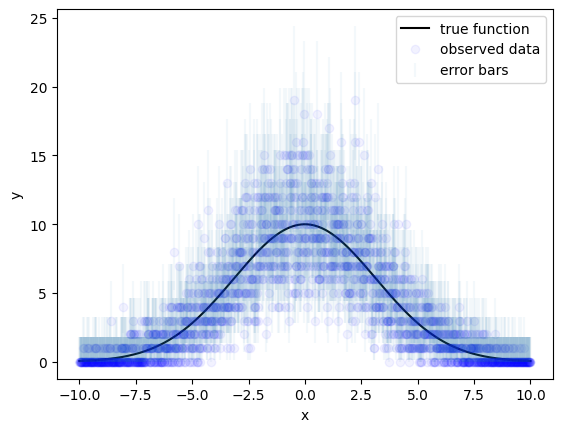

In [7]:
# generate data
x_bin = jnp.linspace(-10,10,2001) # 10 random points between -1 and 1
x = 0.5 * (x_bin[:-1] + x_bin[1:])
log_rate = -(x-mu_tr)**2. / (2. * sigma_tr**2.)
y = N_tr * jnp.exp(log_rate)
y_obs = jax.random.poisson(jax.random.PRNGKey(23),y)

# estimate error bars
yerr = jnp.array([custom.poisson_interval(k) for k in y_obs.T]).T

# plot data with error bars
plt.plot(x, y, 'k', label='true function')
plt.plot(x, y_obs, 'bo', label='observed data', alpha = 0.05)
plt.errorbar(x, y_obs, yerr = yerr, c = 'C0', fmt = 'none', label='error bars', alpha = 0.05)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [8]:
# run SVI
svi, guide = custom.load_svi(model, lr = 0.01, num_particles = 16)
rng_key = jax.random.PRNGKey(0)
svi_results = svi.run(rng_key, 10000, x, y=y_obs)

100%|██████████| 10000/10000 [06:03<00:00, 27.51it/s, init loss: 1349045.2061, avg. loss [9501-10000]: 4516.0038]


In [9]:
# sample from GP posterior using guide sample_posterior function
rng_key, key = jax.random.split(rng_key)
samples = guide.sample_posterior(key, svi_results.params, (1000,))
gp_samples = jnp.exp(samples['log_rate'])

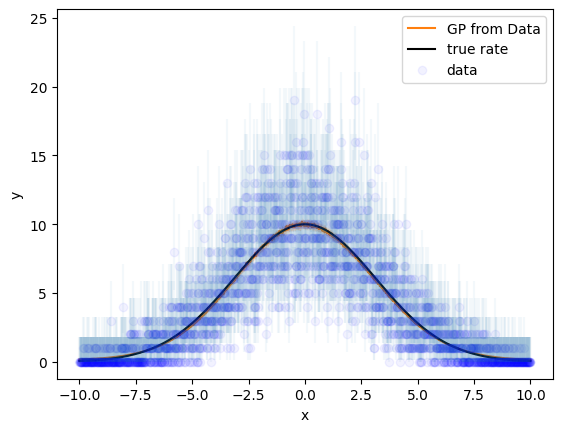

In [10]:
q = np.quantile(gp_samples, [0.16,0.5,0.84], axis = 0)

# plot guide (posterior approximation)
plt.plot(x, q[1], color = 'C1', label = 'GP from Data')
plt.fill_between(
    x,
    q[0],
    q[2],
    alpha=0.3,
    lw=0,
    color="C1",
)

# plot data with error bars 
plt.plot(x, y, "k", label="true rate")
plt.plot(x, y_obs, "bo", label="data", alpha = 0.05)
plt.errorbar(x, y_obs, yerr = yerr, c = 'C0', fmt = 'none', alpha = 0.05)
plt.legend()
plt.xlabel("x")
_ = plt.ylabel("y")

### Sparse GP Implementation
Due to the higher number of datapoints of a standard GP, the fit requires more time and memory to complete. The sparse GP implementation would improve both the time and memory of the fit. The fit typically converges faster for a faster GP due to the lower dimension of the latent space. For comparison, we perform the SVI fit with the same number of steps. 

**Note:** We can make the positions of the inducing points learnable parameters. We do not take this approach for this simple example, as it is unnecessarily complicated to interpret what the model is learning from the inducing point positions.

In [11]:
def model(x, xu, y=None):
    '''
    Numpyro model for 1D Poisson regression with Gaussian Process prior on log_rate

    Parameters
    ----------
    x : array
        x values (where observations are made)
    xu : array
        x values of inducing points
    y : array
        y values (observations)
    '''
    # define GP kernel (with hyperparameters optimized during fitting)
    kernel = custom.load_kernel(before_fit = True)

    # define GP on inducing points
    gp_u = GaussianProcess(kernel, xu, diag = 1e-3)
    log_rate_u = numpyro.sample("log_rate_u", gp_u.numpyro_dist())
    
    # sample GP at x from inducing point samples
    _, gp_x = gp_u.condition(log_rate_u, x, diag=1e-3)
    log_rate = gp_x.sample(key = jax.random.PRNGKey(12))
    rate = jnp.exp(log_rate)
    
    # load function values and compute log likelihood
    numpyro.factor("log_likelihood", log_like_poisson(rate, y)) 

In [12]:
# define inducing points
xu = jnp.linspace(-10,10,20)

# run SVI
svi, guide = custom.load_svi(model, lr = 0.01, num_particles = 16)
rng_key = jax.random.PRNGKey(0)
svi_results = svi.run(rng_key, 10000, x, xu=xu, y=y_obs)

100%|██████████| 10000/10000 [04:02<00:00, 41.27it/s, init loss: 22051.0471, avg. loss [9501-10000]: 3407.9248]


In [13]:
# sample from GP posterior using guide sample_posterior function
pred = Predictive(guide, num_samples = 1000, params = svi_results.params)
rng_key, key = jax.random.split(rng_key)
samples = pred(key, x, xu, y=None)

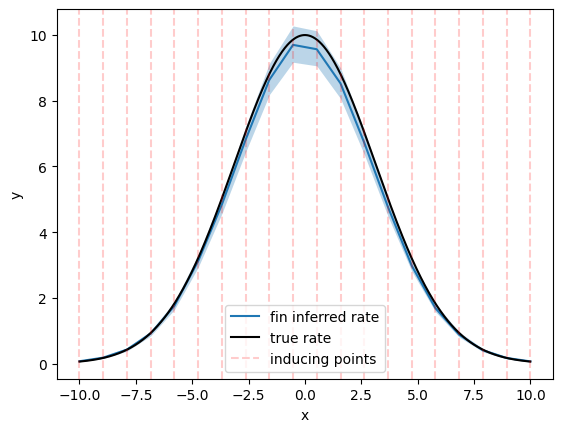

In [14]:
u_samples = jnp.exp(samples["log_rate_u"])
q = np.percentile(u_samples, [5, 50, 95], axis=0)


# plot guide (posterior approximation)
plt.plot(xu, q[1], color="C0", label="fin inferred rate")
plt.fill_between(xu, q[0], q[2], alpha=0.3, lw=0, color="C0")

# plot data with crude error bars 
plt.plot(x, y, "k", label="true rate")

for xu_v in xu:
    if xu_v == xu[0]:
        plt.axvline(xu_v, color="red", linestyle="--", alpha=0.2, label = 'inducing points')
    else:
        plt.axvline(xu_v, color="red", linestyle="--", alpha=0.2)
plt.legend()
plt.xlabel("x")
_ = plt.ylabel("y")

Guide can only be used to draw samples of the inducing points, so we need to convert from that to GP values. We do this by conditioning the GP on the inducing points and then sampling from the GP. Two ways that I have done this involve drawing

In [15]:
# sample the GP at x using custom (vectorized) sampler
rng_key, key = jax.random.split(rng_key)
pred = Predictive(guide, num_samples = 1, params = svi_results.params)
gp_samples = custom.get_gp_samples_at_x_from_u(rng_key, 1000, pred, svi_results.params, x, xu)

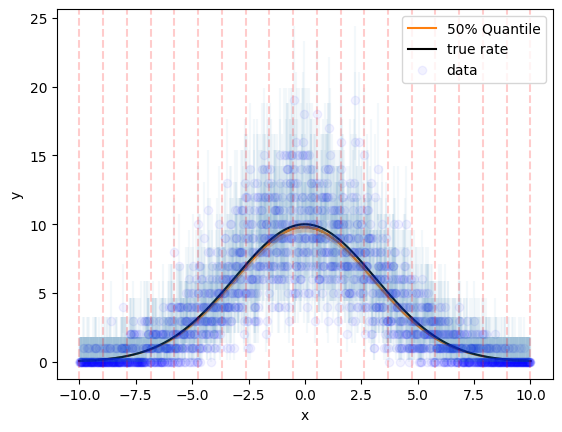

In [16]:
q = np.quantile(gp_samples, [0.16,0.5,0.84], axis = 0)

# plot guide (posterior approximation)
plt.plot(x, np.exp(q[1]), color = 'C1', label = '50% Quantile')
plt.fill_between(
    x,
    np.exp(q[0]),
    np.exp(q[2]),
    alpha=0.3,
    lw=0,
    color="C1",
)

# plot data with error bars
plt.plot(x, y, "k", label="true rate")
plt.plot(x, y_obs, "bo", label="data", alpha = 0.05)
plt.errorbar(x, y_obs, yerr = yerr, c = 'C0', fmt = 'none', alpha = 0.05)
plt.legend()
plt.xlabel("x")
_ = plt.ylabel("y")

for xu_v in xu:
    if xu_v == xu[0]:
        plt.axvline(xu_v, color="red", linestyle="--", alpha=0.2, label = 'inducing points')
    else:
        plt.axvline(xu_v, color="red", linestyle="--", alpha=0.2)

#### Subtle Issue:
During our SVI fit, the same random seed is being used to convert the inducing point sample `log_rate_u` to the desired sample `log_rate`. See the code block below.
````
# load kernel and sample from GP
_, gp_x = gp_u.condition(log_rate_u, x, diag=1e-3)
log_rate = gp_x.sample(key = jax.random.PRNGKey(12))
rate = jnp.exp(log_rate)
````
**Note:** We cannot bypass this problem by using `np.random.randint` to generate the integer in the argument of `jax.random.PRNGKey`. 

To fix this problem, we have to manually update the `PRNGKey` at each SVI step. Instead of modifying `svi.run` to allow for this, we make a bare-bones function that runs the SVI algorithm with the desired `PRNGKey` manual updates. As we show below, manually updating the `PRNGKey` does change the fit slightly.


In [17]:
def model(x, xu, y=None, gp_rng_key = jax.random.PRNGKey(0)):
    '''
    Numpyro model for 1D Poisson regression with Gaussian Process prior on log_rate

    Parameters
    ----------
    x : array
        x values (where observations are made)
    xu : array
        x values of inducing points
    y : array
        y values (observations)
    gp_rng_key : PRNGKey
        random key for sampling from GP
    '''
    # define GP kernel (with hyperparameters optimized during fitting)
    kernel = custom.load_kernel(before_fit = True)

    # define GP on inducing points
    gp_u = GaussianProcess(kernel, xu, diag = 1e-3)
    log_rate_u = numpyro.sample("log_rate_u", gp_u.numpyro_dist())
    
    # sample GP at x from inducing point samples
    _, gp_x = gp_u.condition(log_rate_u, x, diag=1e-3)
    log_rate = gp_x.sample(key = gp_rng_key)
    rate = jnp.exp(log_rate)
    
    # load function values and compute log likelihood
    numpyro.factor("log_likelihood", log_like_poisson(rate, y)) 

In [18]:
# define inducing points
xu = jnp.linspace(-10,10,20)

# run SVI
svi, guide = custom.load_svi(model, lr = 0.01, num_particles = 16)
rng_key = jax.random.PRNGKey(0)
svi_results = custom.svi_loop(rng_key, 10000, svi, x, xu, y_obs)

100%|██████████| 10000/10000 [04:01<00:00, 41.49it/s]


In [19]:
# sample the GP at x using custom (vectorized) sampler
rng_key, key = jax.random.split(rng_key)
pred = Predictive(guide, num_samples = 1, params = svi_results.params)
gp_samples_key_update = custom.get_gp_samples_at_x_from_u(rng_key, 1000, pred, svi_results.params, x, xu)

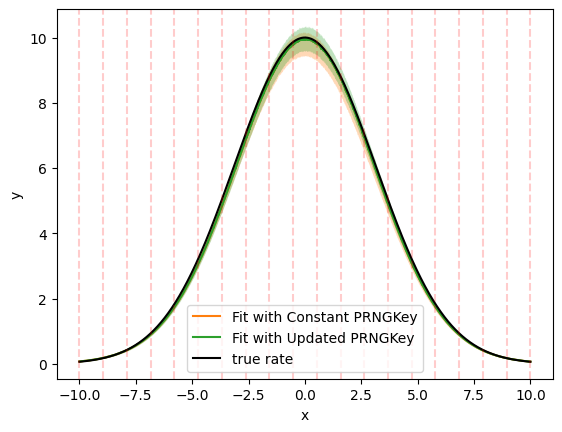

In [20]:
q_k = np.quantile(gp_samples_key_update, [0.16,0.5,0.84], axis = 0)

# plot guide (posterior approximation)
plt.plot(x, np.exp(q_k[1]), color = 'C1', label = 'Fit with Constant PRNGKey')
plt.fill_between(
    x,
    np.exp(q[0]),
    np.exp(q[2]),
    alpha=0.3,
    lw=0,
    color="C1",
)

plt.plot(x, np.exp(q_k[1]), color = 'C2', label = 'Fit with Updated PRNGKey')
plt.fill_between(
    x,
    np.exp(q_k[0]),
    np.exp(q_k[2]),
    alpha=0.3,
    lw=0,
    color="C2",
)

# # plot true rate
plt.plot(x, y, "k", label="true rate")
plt.legend()
plt.xlabel("x")
_ = plt.ylabel("y")

for xu_v in xu:
    if xu_v == xu[0]:
        plt.axvline(xu_v, color="red", linestyle="--", alpha=0.2, label = 'inducing points')
    else:
        plt.axvline(xu_v, color="red", linestyle="--", alpha=0.2)

### Further Speed-Up by Subsampling
With the standard GP implementation, subsampling is useless because we need to load the value of the GP at all input values `x` anyways to compute the log-likelihood. With a sparse GP, subsampling significantly increases the speed of our fit because we only loaded the values of the GP at the sparser set of inducing points. In practice, the number of points used during subsampling can be implemented as an argument in `model`. For simplicity, we just specify the number of subsampling points to be 64 directly inside the `model` function.

For more details on `numpyro` subsampling, see [Conditional Independence, Subsampling, and Amortization][1].

<!-- ### References: -->

[1]: <https://pyro.ai/examples/svi_part_ii.html> "Conditional Independence, Subsampling, and Amortization"

In [21]:
def model(x, xu, y=None, gp_rng_key = jax.random.PRNGKey(0)):
    '''
    Numpyro model for 1D Poisson regression with Gaussian Process prior on log_rate

    Parameters
    ----------
    x : array
        x values (where observations are made)
    xu : array
        x values of inducing points
    y : array
        y values (observations)
    gp_rng_key : PRNGKey
        random key for sampling from GP
    '''
    # define GP kernel (with hyperparameters optimized during fitting)
    kernel = custom.load_kernel(before_fit = True)

    # define GP on inducing points
    gp_u = GaussianProcess(kernel, xu, diag = 1e-3)
    log_rate_u = numpyro.sample("log_rate_u", gp_u.numpyro_dist())
    
    # sample GP at x from inducing point samples
    with numpyro.plate('observe_data', size=len(x), subsample_size=64) as ind:
        _, gp_x = gp_u.condition(log_rate_u, x[ind], diag=1e-3)
        log_rate = gp_x.sample(key = gp_rng_key)
        rate = jnp.exp(log_rate)
    
    # load function values and compute log likelihood
    numpyro.factor("log_likelihood", log_like_poisson(rate, y[ind])) 

In [22]:
# define inducing points
xu = jnp.linspace(-10,10,20)

# run SVI
svi, guide = custom.load_svi(model, lr = 0.01, num_particles = 16)
rng_key = jax.random.PRNGKey(0)
svi_results = custom.svi_loop(rng_key, 10000, svi, x, xu, y_obs)

100%|██████████| 10000/10000 [00:15<00:00, 652.52it/s]


In [24]:
# sample the GP at x using custom (vectorized) sampler
rng_key, key = jax.random.split(rng_key)
pred = Predictive(guide, num_samples = 1, params = svi_results.params)
gp_samples = custom.get_gp_samples_at_x_from_u(rng_key, 1000, pred, svi_results.params, x, xu)

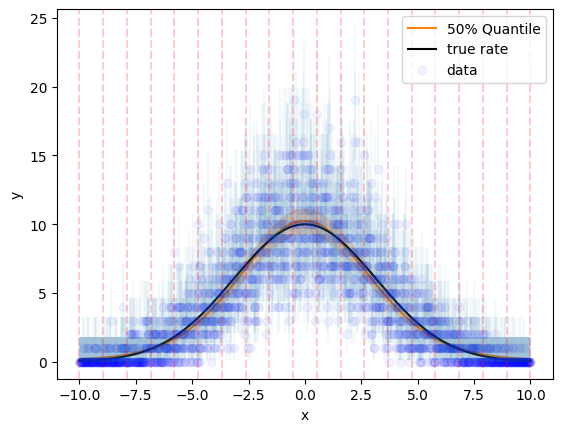

In [25]:
q = np.quantile(gp_samples, [0.16,0.5,0.84], axis = 0)

# plot guide (posterior approximation)
plt.plot(x, np.exp(q[1]), color = 'C1', label = '50% Quantile')
plt.fill_between(
    x,
    np.exp(q[0]),
    np.exp(q[2]),
    alpha=0.3,
    lw=0,
    color="C1",
)

# plot data with error bars
plt.plot(x, y, "k", label="true rate")
plt.plot(x, y_obs, "bo", label="data", alpha = 0.05)
plt.errorbar(x, y_obs, yerr = yerr, c = 'C0', fmt = 'none', alpha = 0.05)
plt.legend()
plt.xlabel("x")
_ = plt.ylabel("y")

for xu_v in xu:
    if xu_v == xu[0]:
        plt.axvline(xu_v, color="red", linestyle="--", alpha=0.2, label = 'inducing points')
    else:
        plt.axvline(xu_v, color="red", linestyle="--", alpha=0.2)

## Appendix A: SVI Basics 

In inference, the basic objective is to develop the best model to explain the available data. The model is defined by observations $x$, latent variables $z$, and parameters $\theta$ distinguishing the model from other models:
\begin{align}
    p_{\theta}(x) = \int p_{\theta}(x,z) \ dz.
\end{align}
Therefore, the objective is achieved by finding the parameter that optimizes the log-evidence:
\begin{align}
    \theta^{*} = \argmax_{\theta} \log p_{\theta}(x).
\end{align}

With the optimal model, we also want to be able to make predictions and estimate uncertainties on the latent variables. That is, we want the posterior $p_{\theta}(z|x)$, which is generally intractable. Stochastic variational inference (SVI) is a scheme for getting around this. One defines the variational distribution (guide) $q_{\phi}(z) \sim p_{\theta}(z|x)$. This condition can be written as:
\begin{equation}
    \phi^{*} = \argmin_{\phi} KL[ \ q_{\phi}(z) \ || \ p_{\theta}(z|x) \ ].
\end{equation}

Therefore, by performing SVI, we are trying to simultaneously find the best model and the best approximation to the posterior. A good start to doing this would be to replacing the posterior in the KL-term above with something more tractable (think in terms of joint distribution).

\begin{align}
    KL[ \ q_{\phi}(z) \ || \ p_{\theta}(z|x) \ ] & = \mathbb{E}_{q(z)} \left [ \log \frac{q(z)}{p(z|x)} \right ] \\
    & = \mathbb{E}_{q(z)} \left [ \log q(z) \right ] - \overset{p(z|x) = p(z,x)/p(x)}{\overline{\mathbb{E}_{q(z)} \left [ \log p(z|x) \right ]}} \\
    & = \mathbb{E}_{q(z)} \left [ \log q(z) \right ] - \mathbb{E}_{q(z)} \left [ \log p(z,x) \right ] +  \underset{\log p(x)}{\underline{\mathbb{E}_{q(z)} \left [ \log p(x) \right ]}}, 
\end{align}
We now have a relationship between the evidence and the similarity between the guide and the true posterior:
\begin{equation}
    \log p_{\theta}(x) = \underset{ELBO}{\underline{\mathbb{E}_{q(z)}\left [ \log p(x,z) - \log q(z) \right ]}} + KL[ \ q_{\phi}(z) \ || \ p_{\theta}(z|x) \ ],
\end{equation}
where $ELBO$ denotes the *{Evidence Lower Bound* (ELBO). This will help us solve the double-optimization problem of SVI. Consider the following two properties of the ELBO:
\begin{align}
    \log p_{\theta}(x) & \geq ELBO \\
    \log p_{\theta}(x) - ELBO & = KL[ \ q_{\phi}(z) \ || \ p_{\theta}(z|x) \ ]
\end{align}
The first property implies that maximizing the ELBO will either move the ELBO closer to the log-evidence or push the log-evidence up with it. If the former occurs, then the guide becomes a better approximation of the posterior in virtue of the second property. If the latter occurs, then the model becomes better at explaining the data.

For more information on SVI, see [Variational Inference - Deriving ELBO][1] for derivation and [An Introduction to Stochastic Variational Inference in Pyro][2] for the `numpyro` implementation of SVI.

<!-- ### Reference: -->

[1]: <https://blog.jakuba.net/variational-inference-deriving-elbo/> "Variational Inference - Deriving ELBO"
[2]: <https://pyro.ai/examples/svi_part_i.html> "Scalable Variational Gaussian Process Classification"


## Appendix B: NumPyro Calculation of Sparse GP ELBO

The `model` and `guide` functions we have defined in our sparse GP implementation determine the form of the ELBO that `numpyro` is using to perform SVI. For a standard GP, the ELBO is given by
$$ ELBO = \mathbb{E}_{q(f)}\left [ \log p(y|f) \right ] - KL[ \ q(f) \ || \ p(f) \ ], $$
where $y$ denotes our observed data and $f$ is the function being sampled by the GP-prior in our model. For our sparse GP `model`, the ELBO is given by
$$ ELBO_{\mathrm sparse} = \mathbb{E}_{q(u)}\left [ \mathbb{E}_{p(f|u)} \left [ \log p(y|f) \right ] \right ] - KL[ \ q(u) \ || \ p(u) \ ]. $$
Thus, this ELBO is optimized with respect to $q(u)$. The approximate posterior of the function-values $f$ are **defined** to be $q(f) \equiv \int p(f|u) \ q(u)$, where $p$ denotes the GP prior. The text below addresses whether or not this ELBO is valid; i.e., does this optimizing this ELBO give us an approximation of the posterior of the function-values $f$?

There are two ways to see that our way of hacking NumPyro to perform Sparse GP SVI is correct. The first method is closer to what NumPyro is actually doing. The second considers a more general theoretical problem. The key point is that we are constraining the possible ways that the guide can approximate the posterior: by the definition $q(f) \equiv \int p(f|u) \ q(u)$, where $p$ denotes the GP prior, reducing the expressibility of the guide.

The guide only approximates the posterior of $u$. There is no underlying prior on $f$.
\begin{align}
    q^{*} = \argmin_{q} KL[ \ q(u) \ || \ p(u|y) \ ].
\end{align}
Running through the crank of the calculation again, the ELBO is given by:
\begin{align}
    ELBO & = \mathbb{E}_{q(u)}\left [ \log p(y,u) - \log q(u) \right ] \\
    & = \mathbb{E}_{q(u)}\left [ \log p(y|u) \right] - KL[ \ q(u) \ || \ p(u) \ ] \\
       & \geq \mathbb{E}_{q(u)}\left [ \mathbb{E}_{p(f|u)} \left [ \log p(y|f) \right ] \right ] - KL[ \ q(u) \ || \ p(u) \ ].
\end{align}
From the perspective of this particular optimization problem, this inequality shows that our NumPyro SVI model in fact adopts a variational bound weaker than the ELBO in this formalism, as the LHS denotes the estimate of log-likelihood that we are using estimate the ELBO and the RHS behaves exactly as it would in normal SVI.

The second approach considers a more general optimization problem, where we define the augmented posterior $p(u,f|x)$ and try to approximate it with the constrained guide $q(u,f) = p(f|u)q(u)$. The optimization problem is thus:
\begin{align}
    & q^{*} = \argmin_{q} KL[ \ q(u,f) \ || \ p(u,f|y) \ ] \\
    & \ : \ q(u,f) = p(f|u) q(u)
\end{align}
The ELBO is then manipulated as before:
\begin{align}
    ELBO & = \mathbb{E}_{q(u,f)}\left [ \log p(y,u,f) - \log q(u,f) \right ] \\
    & = \mathbb{E}_{q(u,f)}\left [ \log p(y|u,f) \right] - \mathbb{E}_{q(u,f)}\left [ \log q(u,f) - \log p(u,f) \right ] \\
       & = \mathbb{E}_{q(u)}\left [ \mathbb{E}_{p(f|u)} \left [ \log p(y|f) \right ] \right ] - \mathbb{E}_{q(u,f)}\left [ \log p(f|u) q(u)  - \log p(f|u) p(u) \right ] \\
       & = \mathbb{E}_{q(u)}\left [ \mathbb{E}_{p(f|u)} \left [ \log p(y|f) \right ] \right ] - \mathbb{E}_{q(u)}\left [ \log q(u) - \log p(u) \right ].
\end{align}
Therefore, in this constrained optimization problem, the generic ELBO is the ELBO that our NumPyro code is taking as the loss function. The key in this derivation is that the prior and the guide share the same conditional distribution $p(f|u)$, allowing for the cancellations in the last line. 